In [1]:
include("SpinGlassCore_3d.jl")
using .SpinGlassCore
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Logging, LinearAlgebra, Statistics, StatsBase, Random
using CairoMakie

seed = 42
Random.seed!(seed)

init_logger(dir="../../logs", level=:Info)
println(names(SpinGlassCore))

[:SpinGlassCore, :calc_acceptance_and_rtt, :calc_energy, :initial_state, :metropolis_sampler, :score_method]


In [2]:
N = 8
β_min = 0.1
β_max = 1.8
M = 20
mcSteps=10^6
Jh = randn(N, N, N)
Jv = randn(N, N, N)
Jz = randn(N, N, N)
@info """
Hyperparameters of Gaussian model:
--------------------
system size: $(N*N*N),
the number of replica: $M,
MCS: $mcSteps
"""
println("Set hyperparameters.")

Set hyperparameters.


In [3]:
β_ladder_trace = [[0.0510579050756008, 0.09301887225780323, 0.13530498745677896, 0.178640527825962, 0.2218279014621579, 0.2668267924003974, 0.31278174710277523, 0.3601817974234092, 0.4098439376522833, 0.4612320593910173, 0.5169917927567094, 0.5765959845825462, 0.6449282406749031, 0.7207362694682575, 0.8082388191236861, 0.910730429582541, 1.0350719577723617, 1.2041254559294863, 1.4441774585923004, 1.7999999999999998]]
geometric_β_ladder = Utils.set_temperature_ladder(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
inverse_linear_β_ladder = Utils.set_temperature_ladder(
    β_min, 
    β_max; 
    M=M, 
    method=:inverse_linear
)
push!(β_ladder_trace, geometric_β_ladder)
push!(β_ladder_trace, inverse_linear_β_ladder)

3-element Vector{Vector{Float64}}:
 [0.0510579050756008, 0.09301887225780323, 0.13530498745677896, 0.178640527825962, 0.2218279014621579, 0.2668267924003974, 0.31278174710277523, 0.3601817974234092, 0.4098439376522833, 0.4612320593910173, 0.5169917927567094, 0.5765959845825462, 0.6449282406749031, 0.7207362694682575, 0.8082388191236861, 0.910730429582541, 1.0350719577723617, 1.2041254559294863, 1.4441774585923004, 1.7999999999999998]
 [0.10000000000000009, 0.11643055668833711, 0.13556074530756068, 0.1578341304124516, 0.18376715668341317, 0.21396112353682642, 0.24911612723054746, 0.29004729373495225, 0.3377036787550609, 0.39319027313151067, 0.45779362385141054, 0.5330116647339088, 0.6205884484634625, 0.7225545852895227, 0.841274326029696, 0.9795003810724302, 1.1404377464470126, 1.3278180168721818, 1.545985908852318, 1.7999999999999998]
 [0.1, 0.18947368421052632, 0.2789473684210526, 0.368421052631579, 0.45789473684210524, 0.5473684210526316, 0.6368421052631579, 0.7263157894736842, 0.815

In [4]:
mean_rtt_trace = []
strategies = ["uniform acceptance", "geometric", "inverse linear"]
rtt_results = Dict{String, Vector{Float64}}()

for (β_ladder, strategy) in zip(β_ladder_trace, strategies)
    all_rtts_trace = []
    for i in 1:20
        p = i * 0.05
        config = SpinGlassCore.initial_state(N; p=p)
        _, all_rtts = SpinGlassCore.calc_acceptance_and_rtt(
            N, 
            config,
            β_ladder,
            Jh,
            Jv,
            Jz;
            mcSteps=mcSteps
        )
        @info "rtts_trace: $all_rtts"
        append!(all_rtts_trace, all_rtts)
    end
    mean_rtt = mean(all_rtts_trace)
    rtt_results[strategy] = convert(Vector{Float64}, all_rtts_trace)

    @info """
        $strategy: 
        inverse temperature ladder = $β_ladder, 
        Mean Round-Trip Time: $mean_rtt ± $(Statistics.std(all_rtts_trace))"""
    println("""
        $strategy: 
        inverse temperature ladder = $β_ladder, 
        Mean Round-Trip Time: $mean_rtt ± $(Statistics.std(all_rtts_trace))"""
    )
end

uniform acceptance: 
inverse temperature ladder = [0.0510579050756008, 0.09301887225780323, 0.13530498745677896, 0.178640527825962, 0.2218279014621579, 0.2668267924003974, 0.31278174710277523, 0.3601817974234092, 0.4098439376522833, 0.4612320593910173, 0.5169917927567094, 0.5765959845825462, 0.6449282406749031, 0.7207362694682575, 0.8082388191236861, 0.910730429582541, 1.0350719577723617, 1.2041254559294863, 1.4441774585923004, 1.7999999999999998], 
Mean Round-Trip Time: 19744.513258245366 ± 14457.423715446044
geometric: 
inverse temperature ladder = [0.10000000000000009, 0.11643055668833711, 0.13556074530756068, 0.1578341304124516, 0.18376715668341317, 0.21396112353682642, 0.24911612723054746, 0.29004729373495225, 0.3377036787550609, 0.39319027313151067, 0.45779362385141054, 0.5330116647339088, 0.6205884484634625, 0.7225545852895227, 0.841274326029696, 0.9795003810724302, 1.1404377464470126, 1.3278180168721818, 1.545985908852318, 1.7999999999999998], 
Mean Round-Trip Time: 25448.18274

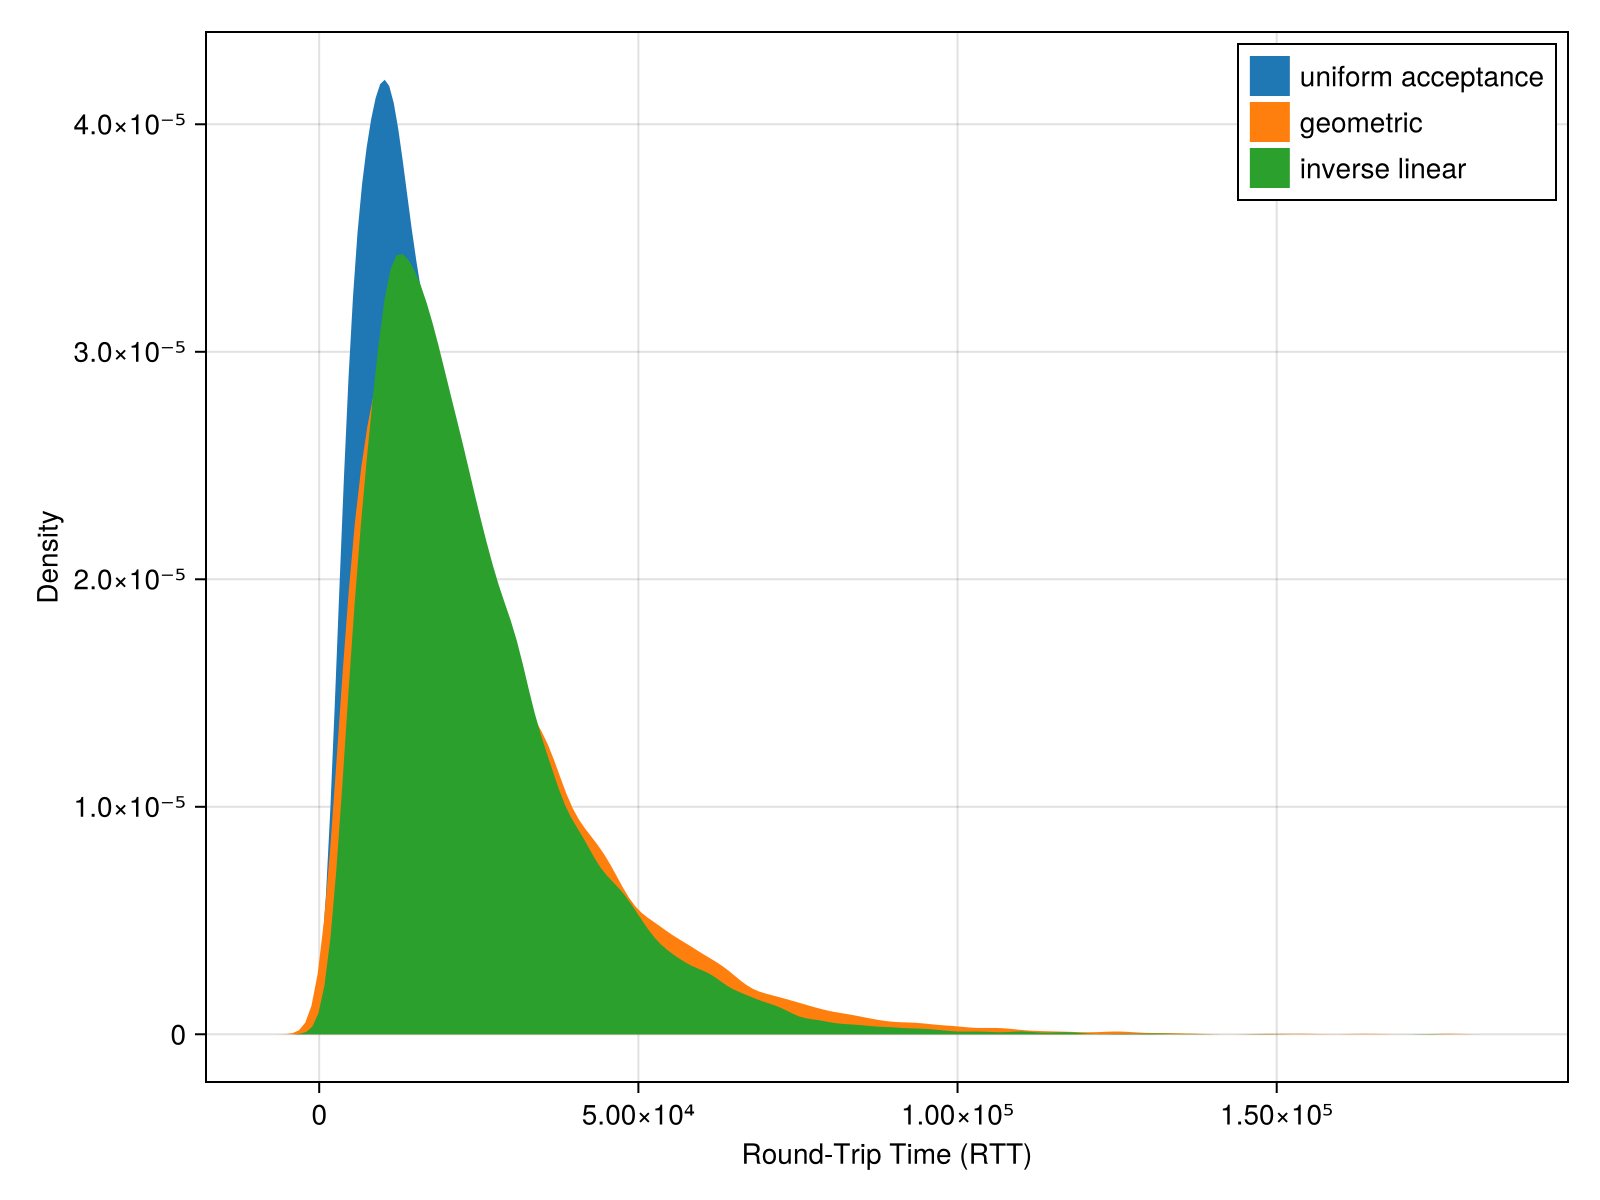

CairoMakie.Screen{IMAGE}


In [10]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1],
    xlabel="Round-Trip Time (RTT)",
    ylabel="Density",
    # title="Distribution of Round-Trip Times for Different Strategies"
)
plot_colors = [colorant"#1f77b4", colorant"#ff7f0e", colorant"#2ca02c"]

for (i, strategy) in enumerate(strategies)
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        density!(ax, rtt_results[strategy], label=strategy, color = plot_colors[i])
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

axislegend(ax)
display(fig)

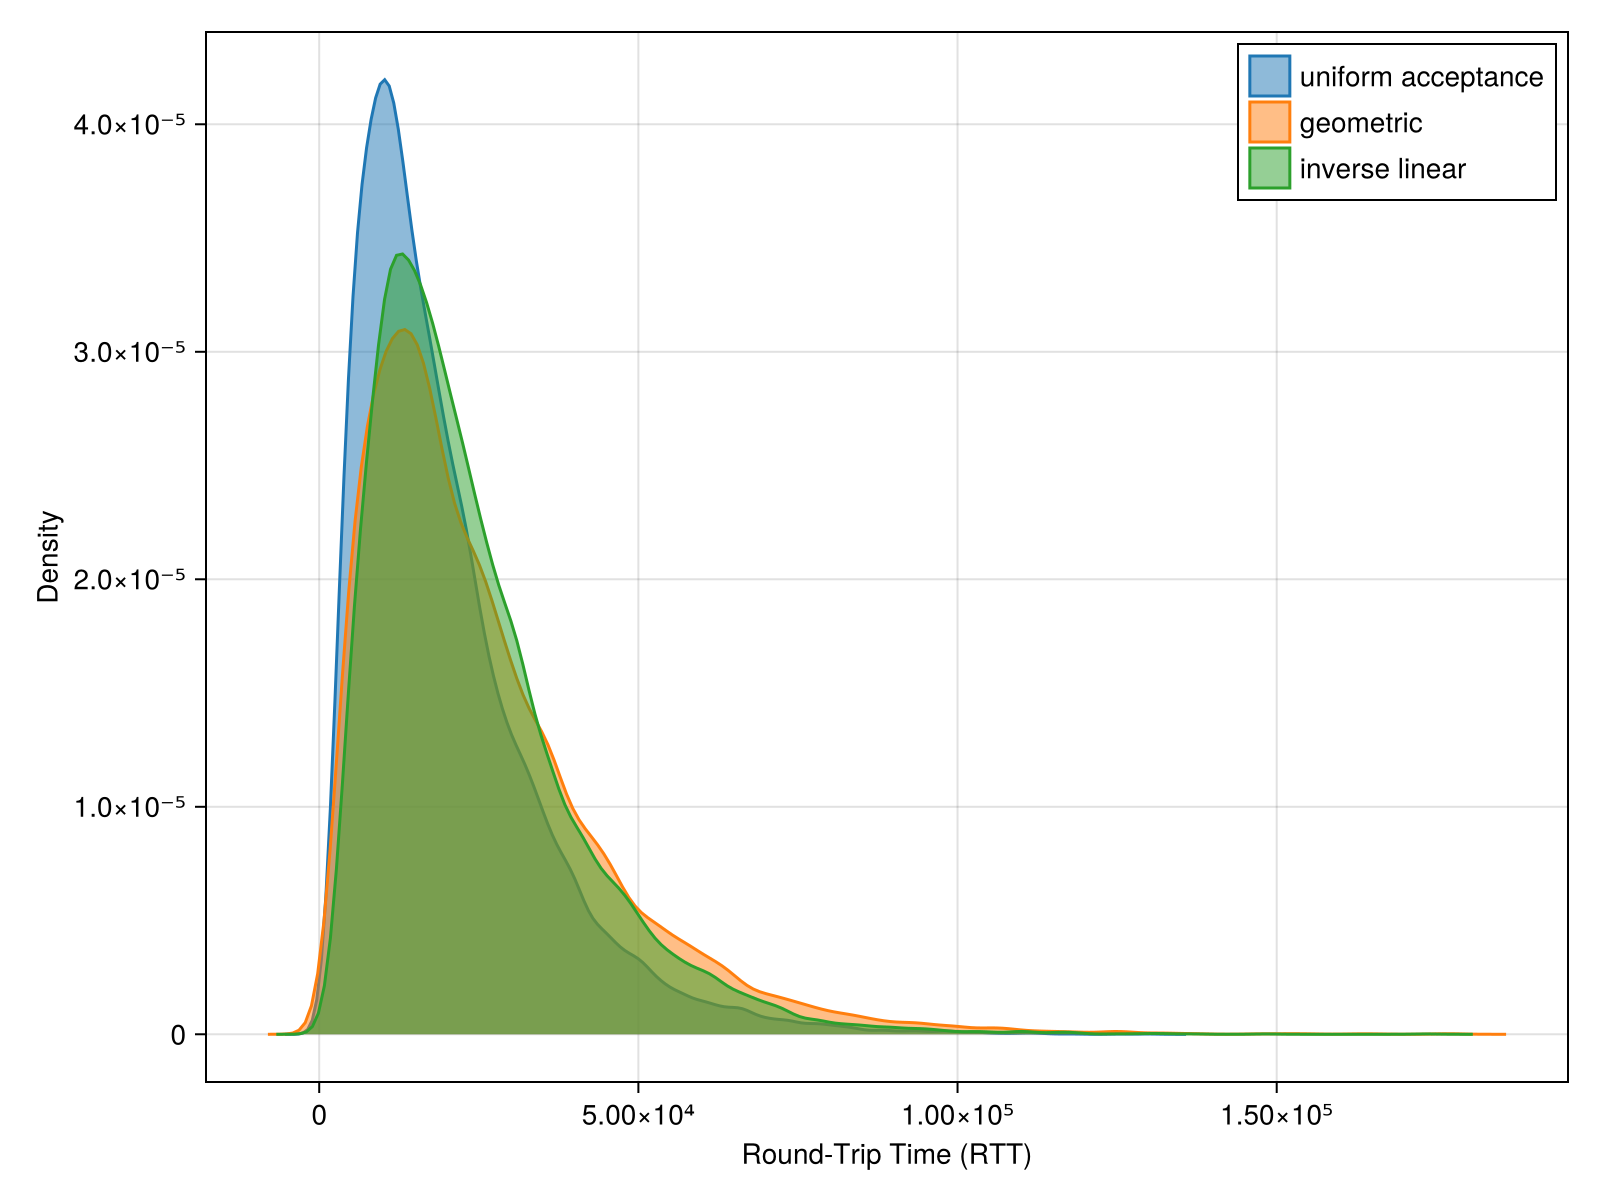

CairoMakie.Screen{IMAGE}


In [6]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1],
xlabel="Round-Trip Time (RTT)",
ylabel="Density",
)

for (i, strategy) in enumerate(strategies)
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        density!(ax, rtt_results[strategy], 
                 label=strategy, 
                 color=(plot_colors[i], 0.5), 
                 strokecolor=(plot_colors[i], 1.0), 
                 strokewidth=1.5)
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

axislegend(ax)
display(fig)

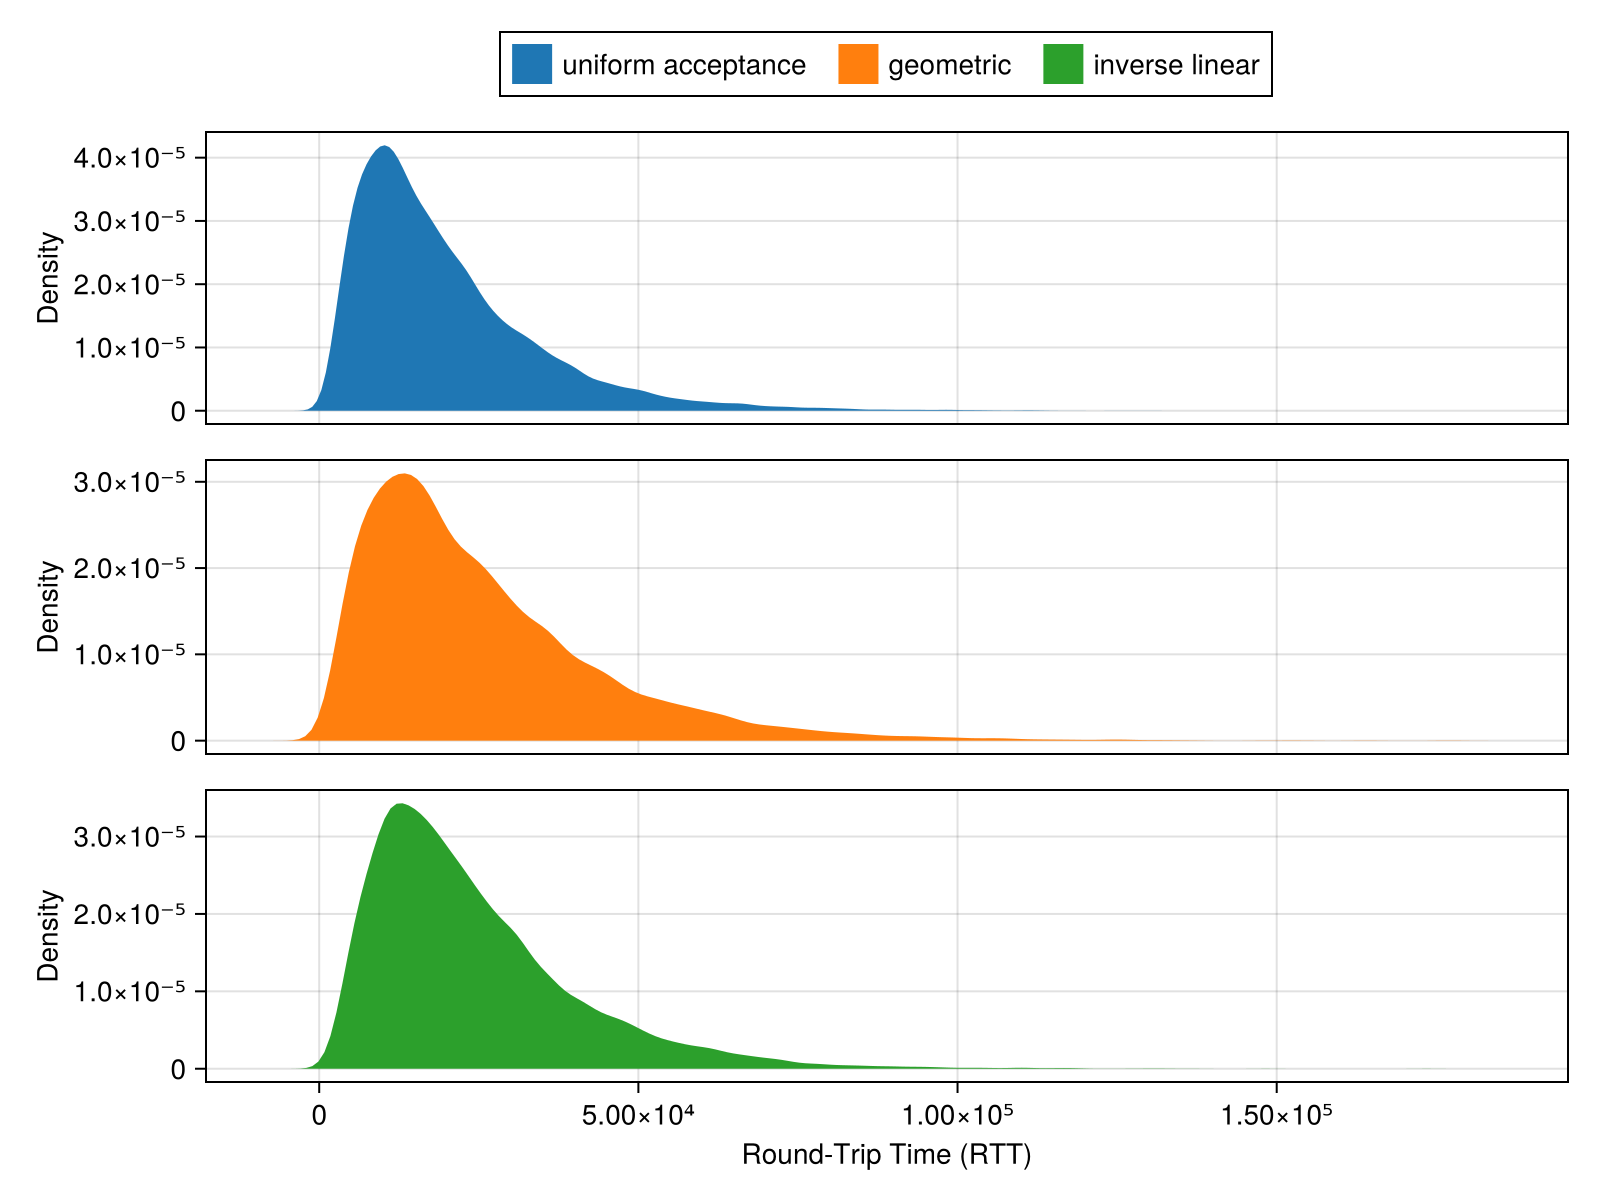

CairoMakie.Screen{IMAGE}


In [7]:
fig = Figure(size=(800, 600))
elements = []
labels = []
axes = Axis[]

for (i, strategy) in enumerate(strategies)
    ax = Axis(fig[i, 1],
        ylabel="Density",
    )
    push!(axes, ax)

    if i < length(strategies)
        hidexdecorations!(ax, grid = false)
    else
        ax.xlabel = "Round-Trip Time (RTT)"
    end
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        d = density!(ax, rtt_results[strategy], color = plot_colors[i])
        push!(elements, d)
        push!(labels, strategy)
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

Legend(fig[0, 1], elements, labels, orientation = :horizontal, halign = :center)
linkxaxes!(axes...)
display(fig)

In [8]:
for strategy in strategies
    println("""
        $strategy: 
        mean RTT = $(mean(rtt_results[strategy]))
        median RTT = $(median(rtt_results[strategy]))
        mode RTT = $(mode(rtt_results[strategy]))
        min RTT = $(minimum(rtt_results[strategy]))
        max RTT = $(maximum(rtt_results[strategy]))
        std RTT = $(std(rtt_results[strategy]))
    """)
end

    uniform acceptance: 
    mean RTT = 19744.513258245366
    median RTT = 15972.0
    mode RTT = 9476.0
    min RTT = 736.0
    max RTT = 129724.0
    std RTT = 14457.423715446044

    geometric: 
    mean RTT = 25448.182748442112
    median RTT = 20500.0
    mode RTT = 16528.0
    min RTT = 626.0
    max RTT = 177272.0
    std RTT = 18904.18431383457

    inverse linear: 
    mean RTT = 24219.372667737553
    median RTT = 20261.0
    mode RTT = 10848.0
    min RTT = 604.0
    max RTT = 173394.0
    std RTT = 16167.021141067467



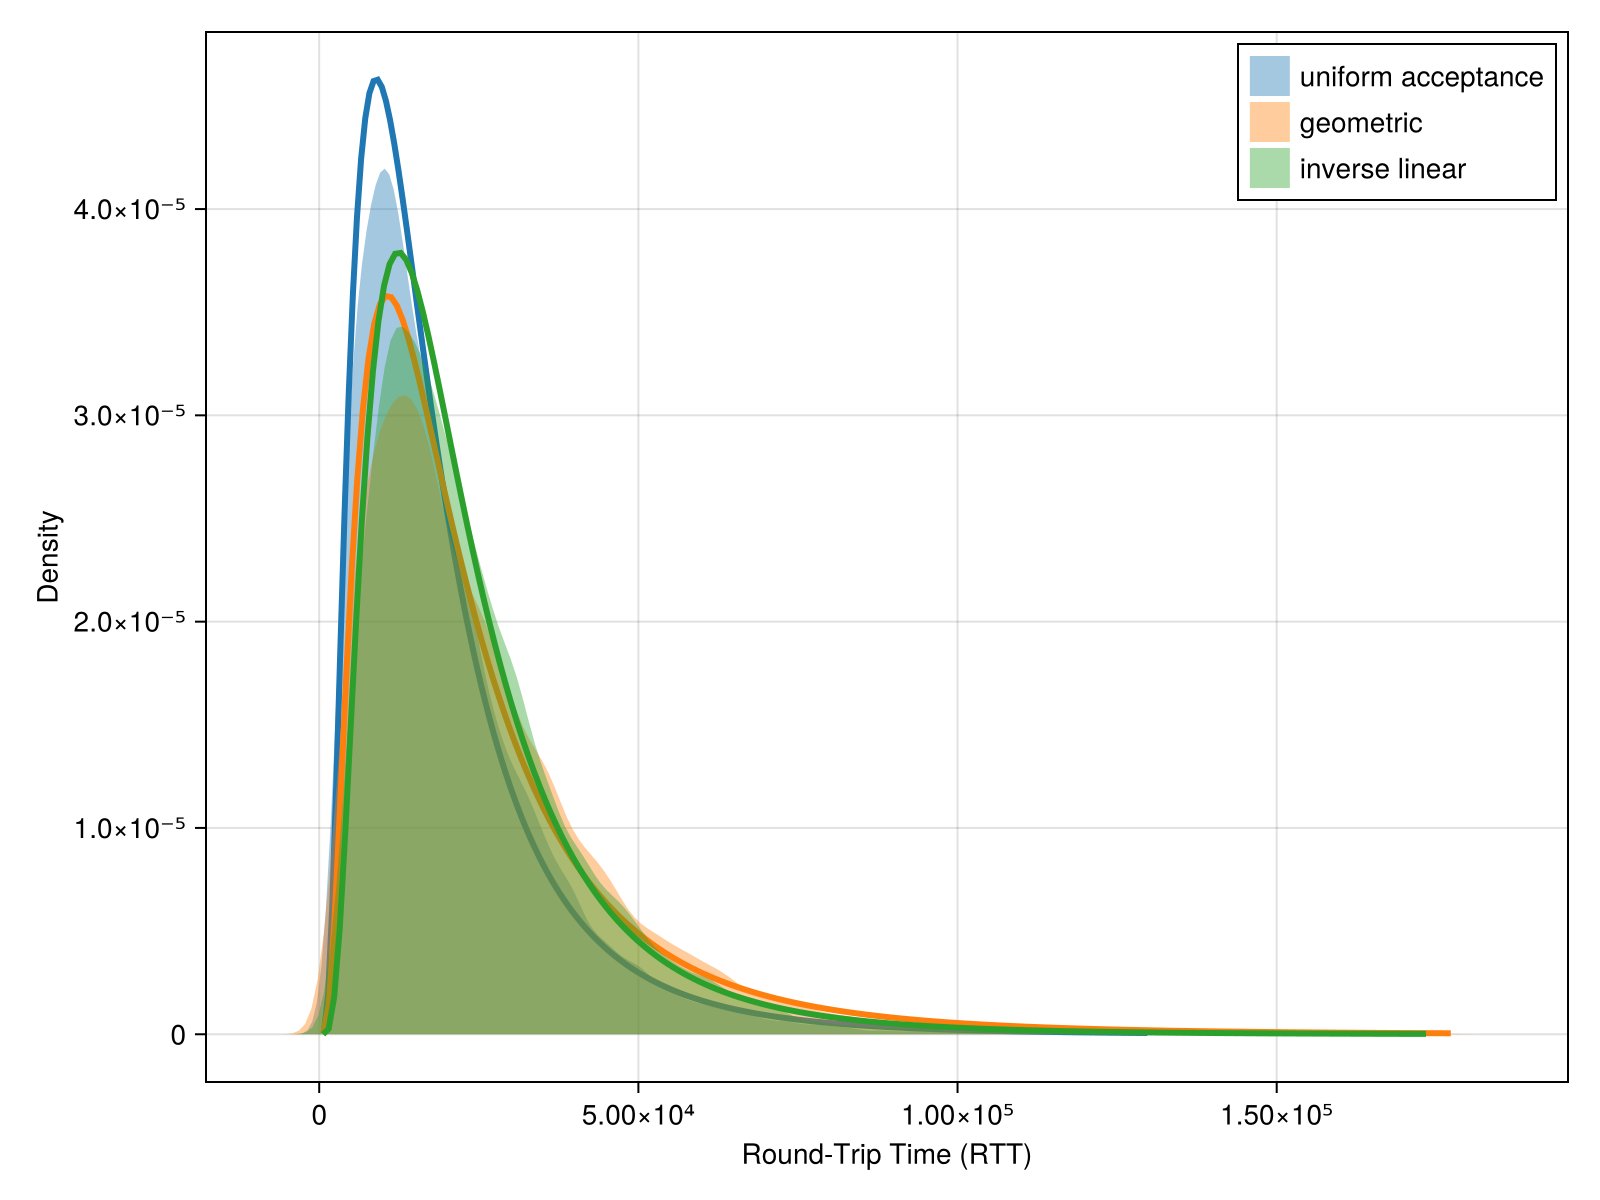

CairoMakie.Screen{IMAGE}


In [11]:
using Distributions

fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1],
    xlabel="Round-Trip Time (RTT)",
    ylabel="Density",
)

for (i, strategy) in enumerate(strategies)
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        data = rtt_results[strategy]
        
        density!(ax, data, label=strategy, color=(plot_colors[i], 0.4))
        
        fitted_dist = fit(LogNormal, data)
        
        x_range = range(minimum(data), maximum(data), length=200)
        y_values = pdf.(fitted_dist, x_range)
        lines!(ax, x_range, y_values, color=plot_colors[i], linewidth=3)
        
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

axislegend(ax)
display(fig)

Strategy: uniform acceptance, Fitted Gamma(α = 2.14, θ = 9239.07)
Strategy: geometric, Fitted Gamma(α = 2.01, θ = 12686.57)
Strategy: inverse linear, Fitted Gamma(α = 2.5, θ = 9676.58)


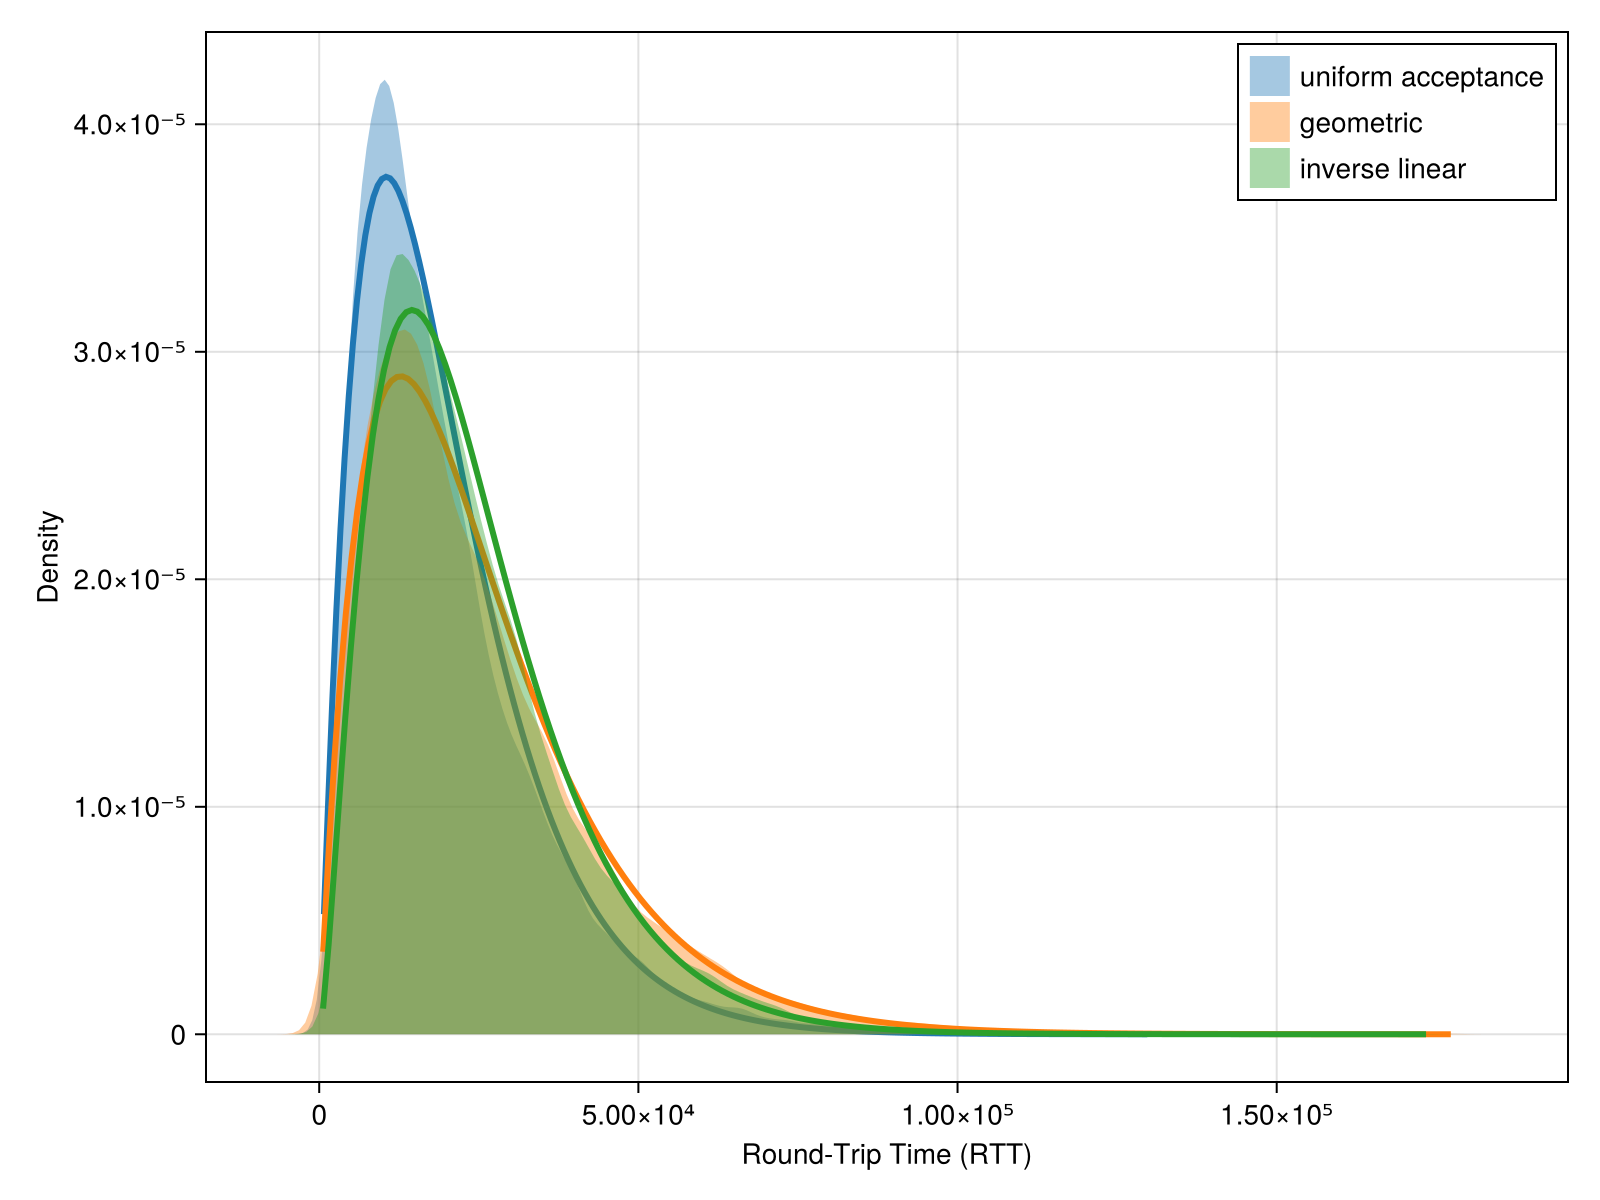

CairoMakie.Screen{IMAGE}


In [12]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1],
    xlabel="Round-Trip Time (RTT)",
    ylabel="Density",
)

for (i, strategy) in enumerate(strategies)
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        data = rtt_results[strategy]
        
        density!(ax, data, label=strategy, color=(plot_colors[i], 0.4))
        
        fitted_dist = fit(Gamma, data)
        
        x_range = range(minimum(data), maximum(data), length=200)
        y_values = pdf.(fitted_dist, x_range)
        lines!(ax, x_range, y_values, color=plot_colors[i], linewidth=3)
        
        println("Strategy: $(strategy), Fitted Gamma(α = $(round(fitted_dist.α, digits=2)), θ = $(round(fitted_dist.θ, digits=2)))")
        
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

axislegend(ax)
display(fig)